Physics of Complex Systems - Machine Learning course

Elia Bronzo and Shoichi Yip

# Introduction

The code for this tutorial was mainly inspired by the one available on [Alexander Van de Kleut's website](https://avandekleut.github.io/vae/).

In this tutorial we will see how to write **variational autoencoders** in PyTorch, and how to train them. We will attempt to connect the results that we get from a theoretical line of reasoning in terms of an actual neural network. Our benchmark dataset of choice will be **MNIST**.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# The Variational Autoencoder

## The encoder

The encoder of our **variational autoencoder** is made of the following small building blocks:

- the **input**
- a **hidden layer** that is fully connected to the input by `linear1`
- a pair of **two parallel hidden layers** that store the parameters of means and standard deviations of the multivariate gaussians

The **forward pass** consists of:

- flattening the input array and passing it to the first hidden layer with the use of a ReLU activation function
- passing the output of the ReLU to both the $\mu$ and the $\sigma$ block
- using the **reparametrization trick** to sample and fix a value in the latent space
- the output of the encoder is the $z$ value due to the sampling

Let us notice two intersting things: first of all, we are storing the values of $e^\sigma$ instead of $\sigma$. This is related to the small values that $\sigma$ might assume, so we choose to scale it like this for computational purposes. Also, notice that we keep track of the Kullback-Leibler divergence. It will be used in the computation of the total loss.

## The decoder

The decoder has a similar structure, but in the reversed order.

The point in the latent space (now fixed thanks to the reparametrization trick) is upsampled to the hidden layer with a ReLU activation function, then passed to the output with a sigmoid activation function since we want values between 0 and 1.

## Defining the class

In [9]:
class VariationalEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(VariationalEncoder, self).__init__()
    self.linear1 = nn.Linear(784, 512)
    self.linear2 = nn.Linear(512, latent_dims)
    self.linear3 = nn.Linear(512, latent_dims)
    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda()
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)

    # first (and only) hidden layer of the encoder
    x = F.relu(self.linear1(x))

    # latent variables layers
    z_mu = self.linear2(x)
    z_log_var = self.linear3(x)

    # reparametrization trick
    eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
    z = z_mu + eps * torch.exp(z_log_var/2.)

    # KL divergence
    self.kl = -.5 * torch.sum(1 + z_log_var - z_mu**2 - torch.exp(z_log_var), axis=1).mean()

    return z

class Decoder(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 784)

  def forward(self, z):
    # hidden layer of the decoder
    z = F.relu(self.linear1(z))

    # output
    z = torch.sigmoid(self.linear2(z))
    return z.reshape((-1, 1, 28, 28))

The Variational Autoencoder is then defined as the combination of the encoder and the decoder.

In [10]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

We can train the VAE by using the Adam optimizer (which, by the way, was also devised by Diederik Kingma). We can see here that we are combining the loss given by

In [11]:
def train(autoencoder, data, epochs=20):
  losses = []

  # choose an optimizer
  opt = torch.optim.Adam(autoencoder.parameters())

  # start the training
  for epoch in range(epochs):
    if (epoch > 0): print(f"Current loss is: {loss}.")
    print(f"Training Epoch #{epoch}")
    for x, y in data:
      # send to gpu
      x = x.to(device)

      # set parameters to zero
      opt.zero_grad()

      # define the forward pass
      x_hat = autoencoder(x)

      # the final loss function
      loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl

      # backpropagate and optimize
      loss.backward()
      opt.step()
    losses.append(loss)
  print(f"Final loss: {loss}. Training completed.")
  return autoencoder, losses

In [12]:
mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

In [13]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

In [14]:
vae = VariationalAutoencoder(2).to(device) # GPU
vae, losses = train(vae, data_loader, epochs=20)

Training Epoch #0
Current loss is: 1254.5552978515625.
Training Epoch #1
Current loss is: 1220.3812255859375.
Training Epoch #2
Current loss is: 1262.4156494140625.
Training Epoch #3
Current loss is: 1114.981689453125.
Training Epoch #4
Current loss is: 1095.5435791015625.
Training Epoch #5
Current loss is: 1137.3807373046875.
Training Epoch #6
Current loss is: 1077.4176025390625.
Training Epoch #7
Current loss is: 1111.5274658203125.
Training Epoch #8
Current loss is: 1070.140869140625.
Training Epoch #9
Current loss is: 1021.9209594726562.
Training Epoch #10
Current loss is: 1152.03955078125.
Training Epoch #11
Current loss is: 955.765625.
Training Epoch #12
Current loss is: 1012.8344116210938.
Training Epoch #13
Current loss is: 1006.9403076171875.
Training Epoch #14
Current loss is: 939.814208984375.
Training Epoch #15
Current loss is: 1105.7694091796875.
Training Epoch #16
Current loss is: 1047.203125.
Training Epoch #17
Current loss is: 1004.2894287109375.
Training Epoch #18
Curr

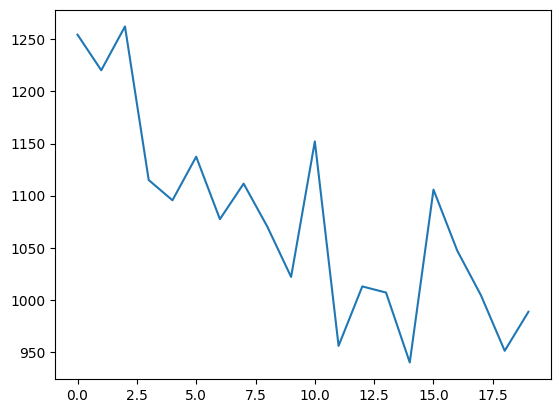

In [15]:
plt.figure()
plt.plot([loss.to('cpu').detach().numpy() for loss in losses])
plt.show()

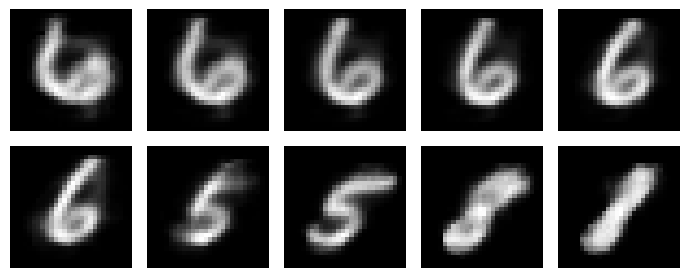

In [16]:
fig, axs = plt.subplots(2, 5, figsize=(7, 3))
for i in range(10):
  z = torch.Tensor([0, i*.5 - 2.5]).to(device)
  x_hat = vae.decoder(z)
  x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
  axs[i//5][i%5].imshow(x_hat, cmap='gray')
  axs[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

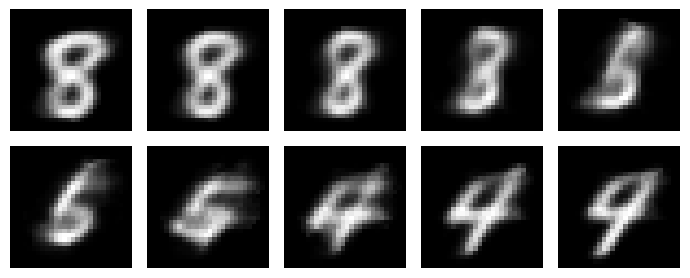

In [17]:
fig, axs = plt.subplots(2, 5, figsize=(7, 3))
for i in range(10):
  z = torch.Tensor([i*.5 - 2.5, .4]).to(device)
  x_hat = vae.decoder(z)
  x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
  axs[i//5][i%5].imshow(x_hat, cmap='gray')
  axs[i//5][i%5].axis('off')
plt.tight_layout()
plt.show()

# Changing the hyperparameters

We can try to train a VAE with an additional layer in the encoder and in the decoder. Let's see how this goes.

In [ ]:
class VariationalEncoder(nn.Module):
  def __init__(self, latent_dims):
    super(VariationalEncoder, self).__init__()
    self.linear1 = nn.Linear(784, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, latent_dims)
    self.linear4 = nn.Linear(256, latent_dims)
    self.N = torch.distributions.Normal(0, 1)
    self.N.loc = self.N.loc.cuda()
    self.N.scale = self.N.scale.cuda()
    self.kl = 0

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)

    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))

    # latent variables layers
    mu = self.linear3(x)
    sigma = torch.exp(self.linear4(x))

    # reparametrization trick
    z = mu + sigma * self.N.sample(mu.shape)

    # KL divergence
    self.kl = (sigma**2 + mu**2 - .5).sum()

    return z

class Decoder(nn.Module):
  def __init__(self, latent_dims):
    super(Decoder, self).__init__()
    self.linear1 = nn.Linear(latent_dims, 512)
    self.linear2 = nn.Linear(512, 256)
    self.linear3 = nn.Linear(256, 784)

  def forward(self, z):
    # hidden layer of the decoder
    z = F.relu(self.linear1(z))
    z = F.relu(self.linear2(z))

    # output
    z = torch.sigmoid(self.linear3(z))
    return z.reshape((-1, 1, 28, 28))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
def train(autoencoder, data, epochs=20):
  losses = []

  # choose an optimizer
  opt = torch.optim.Adam(autoencoder.parameters())

  # start the training
  for epoch in range(epochs):
    if (epoch > 0): print(f"Current loss is: {loss}.")
    print(f"Training Epoch #{epoch}")
    for x, y in data:
      # send to gpu
      x = x.to(device)

      # set parameters to zero
      opt.zero_grad()

      # define the forward pass
      x_hat = autoencoder(x)

      # the final loss function
      loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl

      # backpropagate and optimize
      loss.backward()
      opt.step()
    losses.append(loss)
  print(f"Final loss: {loss}. Training completed.")
  return autoencoder, losses

In [ ]:
vae = VariationalAutoencoder(2).to(device) # GPU
vae, losses = train(vae, data_loader, epochs=20)

Training Epoch #0
Current loss is: 1334.220703125.
Training Epoch #1
Current loss is: 1193.9053955078125.
Training Epoch #2
Current loss is: 992.9072265625.
Training Epoch #3
Current loss is: 1008.06640625.
Training Epoch #4
Current loss is: 956.8782348632812.
Training Epoch #5
Current loss is: 822.7652587890625.
Training Epoch #6
Current loss is: 1010.0339965820312.
Training Epoch #7
Current loss is: 912.2724609375.
Training Epoch #8
Current loss is: 832.0512084960938.
Training Epoch #9
Current loss is: 903.2936401367188.
Training Epoch #10
Current loss is: 913.4634399414062.
Training Epoch #11
Current loss is: 976.12353515625.
Training Epoch #12
Current loss is: 749.10595703125.
Training Epoch #13
Current loss is: 888.8031616210938.
Training Epoch #14
Current loss is: 777.849609375.
Training Epoch #15
Current loss is: 810.5201416015625.
Training Epoch #16
Current loss is: 930.6381225585938.
Training Epoch #17
Current loss is: 1004.5806274414062.
Training Epoch #18
Current loss is: 77

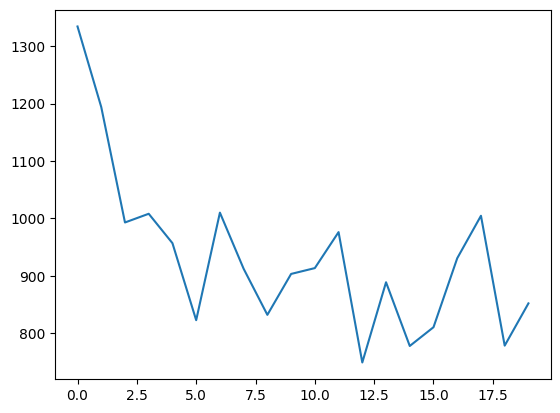

In [ ]:
plt.figure()
plt.plot([loss.to('cpu').detach().numpy() for loss in losses])
plt.show()

The performance seemed improved with respect to the previous case. What if we change the dimensionality of the latent space? Let us remember that we want **undercompleteness**, so we expect that this might not improve necessarily the learning process.

In [ ]:
vae = VariationalAutoencoder(3).to(device) # GPU
vae, losses = train(vae, data_loader, epochs=20)

Training Epoch #0
Current loss is: 938.6672973632812.
Training Epoch #1
Current loss is: 1001.906005859375.
Training Epoch #2
Current loss is: 796.2753295898438.
Training Epoch #3
Current loss is: 864.5875854492188.
Training Epoch #4
Current loss is: 875.413330078125.
Training Epoch #5
Current loss is: 739.113525390625.
Training Epoch #6
Current loss is: 794.2377319335938.
Training Epoch #7
Current loss is: 763.6670532226562.
Training Epoch #8
Current loss is: 880.3681030273438.
Training Epoch #9
Current loss is: 797.0692749023438.
Training Epoch #10
Current loss is: 780.9877319335938.
Training Epoch #11
Current loss is: 636.6368408203125.
Training Epoch #12
Current loss is: 690.6210327148438.
Training Epoch #13
Current loss is: 736.943115234375.
Training Epoch #14
Current loss is: 801.5693359375.
Training Epoch #15
Current loss is: 816.8530883789062.
Training Epoch #16
Current loss is: 658.4133911132812.
Training Epoch #17
Current loss is: 681.6329956054688.
Training Epoch #18
Current

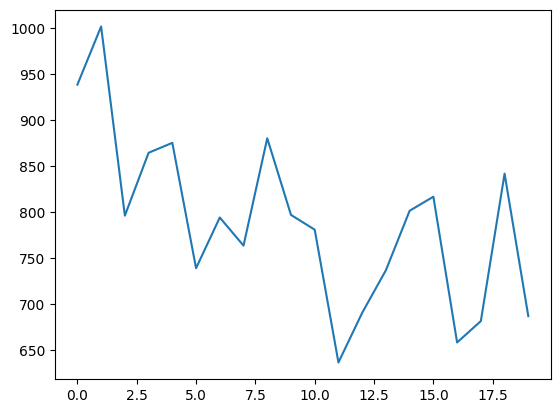

In [ ]:
plt.figure()
plt.plot([loss.to('cpu').detach().numpy() for loss in losses])
plt.show()

We see that, in fact, performance are on average the same as the previous case.

# References

- The code this notebook contains are mostly taken from [Alexander Van de Kleut's blog](https://avandekleut.github.io/vae/)
- [Intuitively understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [Tutorial on Variational Autoencoders with a concise Keras implementation](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)
- [What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)